In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import path
import matplotlib.patches as patches
from skimage import draw
import scipy.ndimage as ndimage
import Utils
import georasters as gr
import cv2
from Utils import doubleMADsfromMedian
from skimage.transform import resize

/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


# Read Image

<Figure size 432x288 with 0 Axes>

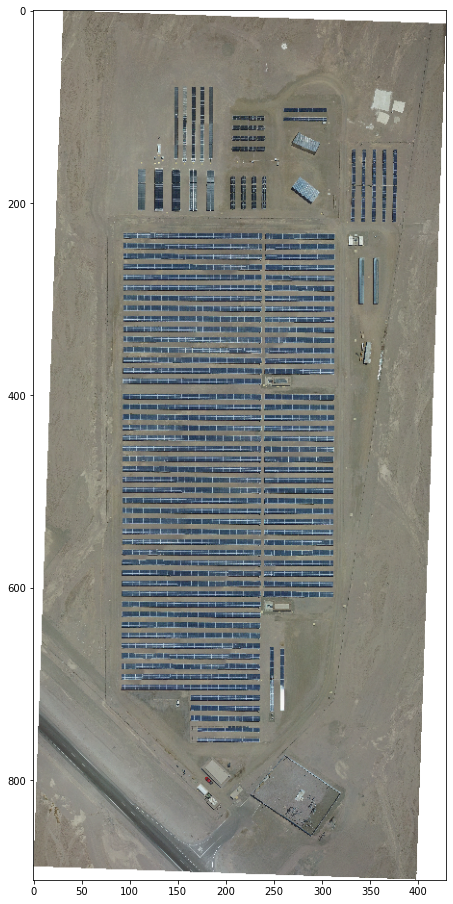

In [2]:
#path_C = "El_Aguila/result_C.tif"
path_RGB = "El_Aguila_2020/RGB.tif"
path_T = "El_Aguila_2020/Thermo.tif"

GR = gr.from_file(path_RGB)

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow((GR.raster[:3,:,:]).transpose((1, 2, 0))[::10,::10,:])

HSV = Utils.rgb2hsv((GR.raster[:3,:,:]).transpose((1, 2, 0)))


# Segmentatio Panel_Strings

<Figure size 432x288 with 0 Axes>

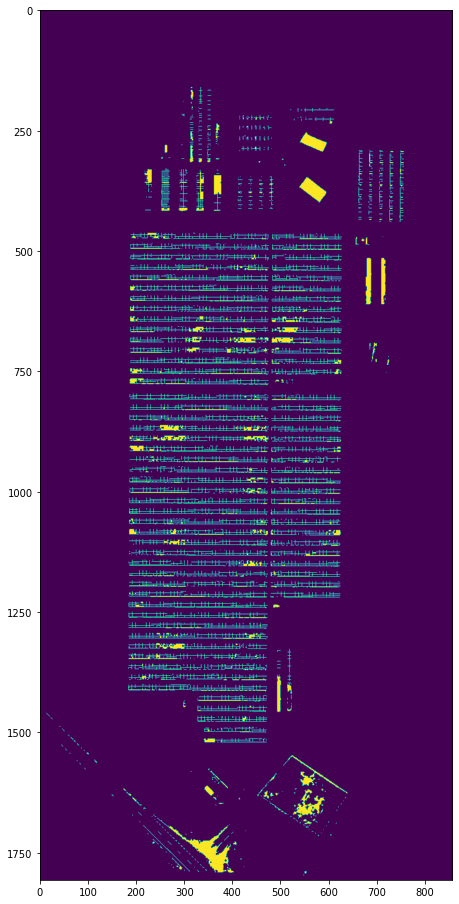

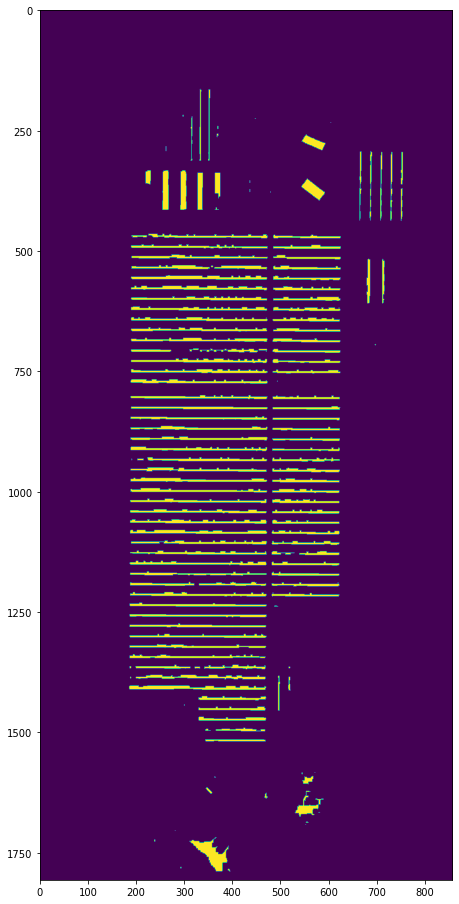

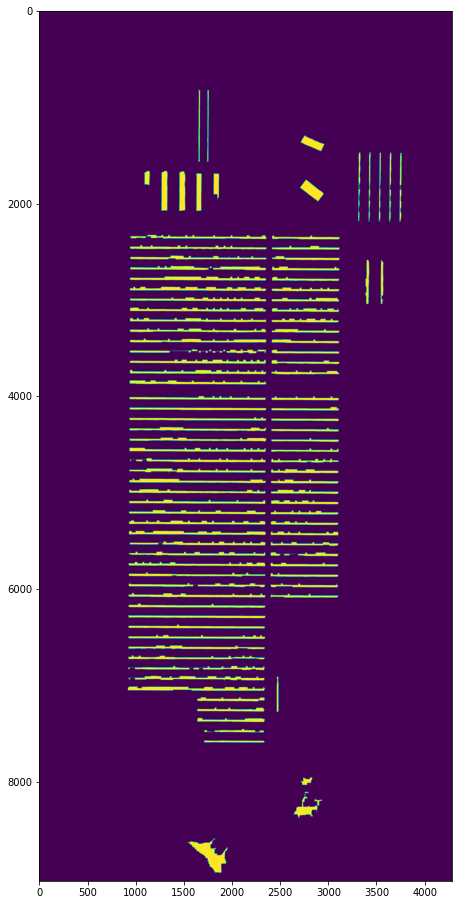

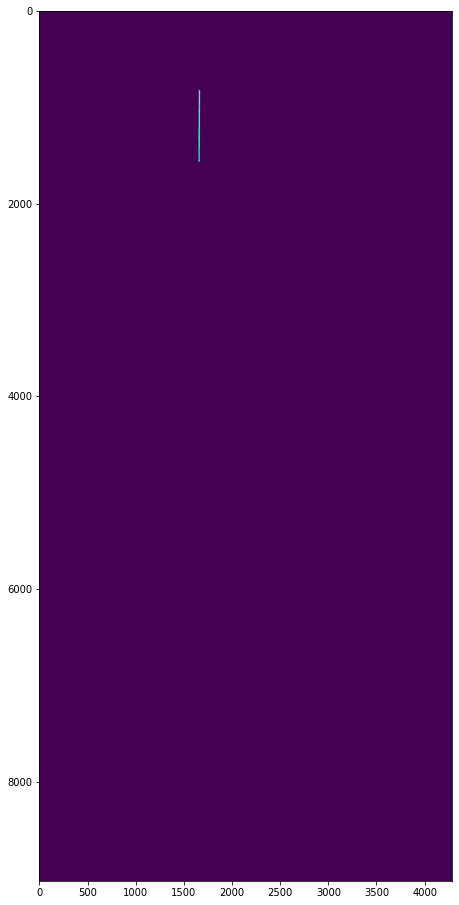

In [9]:
V_thresh = 125
H_top = 240
H_bot = 150

kernel_size = 31
H = cv2.GaussianBlur(HSV[:, :, 0],(kernel_size, kernel_size),0)

H2 = np.ones(H.shape)
#H2 = cv2.GaussianBlur(H2,(9,9),0).astype('float32')
H2[H > H_top] = 0
#H2[H < 270] = 1
H2[H < H_bot] = 0

V = np.zeros(HSV.shape[:2])
V = cv2.normalize(HSV[:, :, 2], V, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
V1 = (V > V_thresh).astype(np.uint8)
V1 = cv2.morphologyEx(V1, cv2.MORPH_CLOSE, np.ones((3,3), dtype=np.uint8),iterations = 5)
H2[V1 == 0] = 0

kernel = np.ones((21, 21) , np.uint8)  # note this is a vertical kernel
closing_H2 = cv2.morphologyEx(H2.astype(float), cv2.MORPH_CLOSE, kernel)
erode_H2 = cv2.morphologyEx(closing_H2.astype(float), cv2.MORPH_ERODE, kernel)




label_im, nb_labels = ndimage.label(erode_H2)#, structure= np.ones((2,2))) ## Label each connect region
label_areas = np.bincount(label_im.ravel())[1:]

min_area = 5000
L = np.zeros(label_im.shape)

for i in range(nb_labels):
    if label_areas[i] > min_area:
        L[label_im == (i + 1) ] = 1
        
        
label_im2, nb_labels2 = ndimage.label(L)#, structure= np.ones((2,2))) ## Label each connect region
label_areas2 = np.bincount(label_im2.ravel())[1:]


plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(H2[::5,::5])

plt.figure(1)
plt.figure(figsize=(16, 16))
plt.imshow(erode_H2[::5,::5])

plt.figure(2)
plt.figure(figsize=(16, 16))
plt.imshow(L)

plt.figure(3)
plt.figure(figsize=(16, 16))
plt.imshow(label_im2==1)
        

# Save Panel_Strings coordinate

<Figure size 432x288 with 0 Axes>

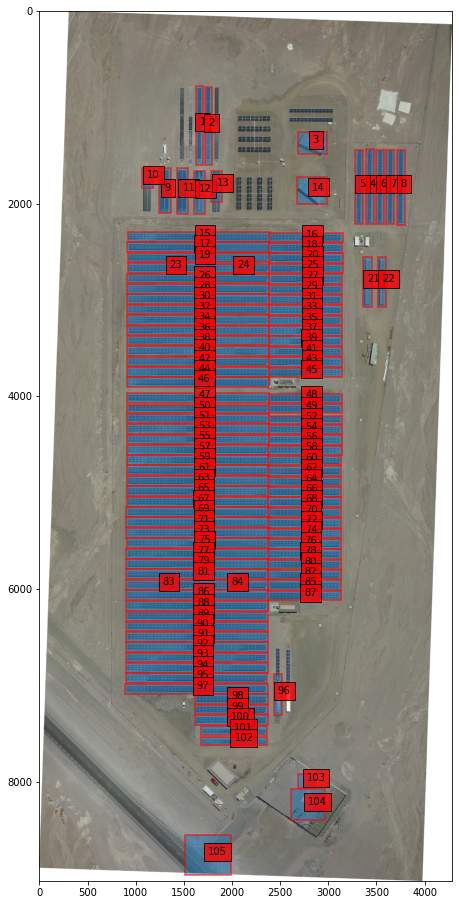

In [10]:
L_strings = [] # {name: '001', points:(top-left, top-right, bottom-right, bottom-left) (x,y), 'panels' : }

epsilon = 30


for i in range(1, nb_labels2 + 1):
    
    countours, hierarchy = cv2.findContours(np.uint8(label_im2 == i), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x_max = np.max(countours[0][:, 0, 0]) + epsilon
    y_max = np.max(countours[0][:, 0, 1]) + epsilon
    x_min = np.min(countours[0][:, 0, 0]) - epsilon
    y_min = np.min(countours[0][:, 0, 1]) - epsilon
    
    List_P = np.array([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])

    L_strings.append({'id': i, 'points' : List_P, 'panels' : []})

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow((GR.raster[:3,:,:]).transpose((1, 2, 0)))

ax = plt.gca()

for Poly in L_strings:
    
    poly = patches.Polygon(Poly['points'],
                     linewidth=2,
                     edgecolor='red',
                     alpha=0.5,
                     fill = True)
    plt.text(np.mean([x[0]  for x in Poly['points']]), np.mean([y[1]  for y in Poly['points']]) , str(Poly['id']),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)
    


# Segmentation Panel and save coordinates

<Figure size 432x288 with 0 Axes>

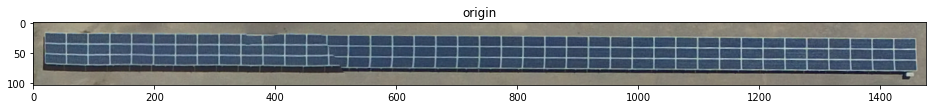

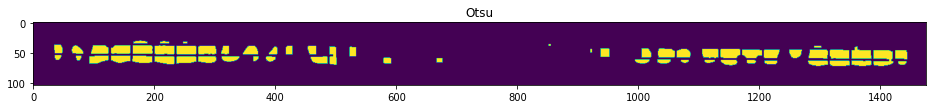

<Figure size 432x288 with 0 Axes>

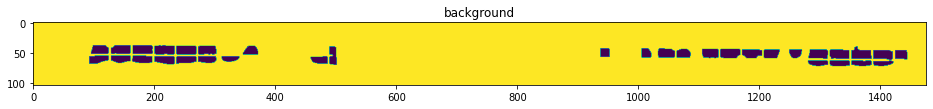

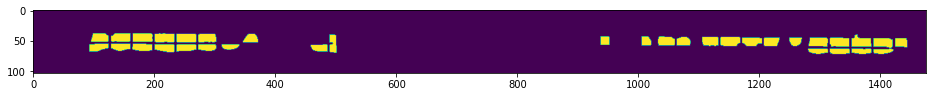

In [23]:
V_thresh = 100


for Poly in L_strings[60:61]:
    
    P = Poly['points']
    x_min = np.min(P[:,0])
    x_max = np.max(P[:,0])
    y_min = np.min(P[:,1]) 
    y_max = np.max(P[:,1])
    A = (GR.raster[:3,:,:]).transpose((1, 2, 0))[y_min : y_max, x_min : x_max,:]

    # rotate clockwise if vertival panel
    if (x_max-x_min) < (y_max-y_min):
        A = cv2.rotate(A, cv2.ROTATE_90_CLOCKWISE);

    HSV_A = Utils.rgb2hsv(A)

    H = cv2.GaussianBlur(HSV_A[:, :, 0],(kernel_size, kernel_size),0)
    S = np.zeros(HSV_A.shape[:2])
    S = cv2.normalize(HSV_A[:, :, 1], S, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    V = np.zeros(HSV_A.shape[:2])
    V = cv2.normalize(HSV_A[:, :, 2], V, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    kernel_size = 31
    H = cv2.GaussianBlur(H,(kernel_size, kernel_size),0)
    Hs = np.ones(H.shape)
    Hs[H > 270] = 0
    Hs[H < 210] = 0

    G = cv2.cvtColor(A,cv2.COLOR_RGB2GRAY)

    ## Otsu in gray, Saturation and value channel ###

    V1 = (V > V_thresh).astype(np.uint8)
    V1 = cv2.morphologyEx(V1, cv2.MORPH_CLOSE, np.ones((3,3), dtype=np.uint8),iterations = 5)

    G = cv2.cvtColor(A,cv2.COLOR_RGB2GRAY)
    G[V1 == 0] = np.mean(G)
    _, G = cv2.threshold(cv2.GaussianBlur(G, (3, 3),0), 0, 255 , cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    G[V1 == 0] = 0
    G[Hs == 0] = 0

    thresh = G 
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((3,3), dtype=np.uint8),iterations = 1)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,  np.ones((3,3), dtype=np.uint8), iterations = 1)

    ### Use Watershed in thresh segmentation
    Areas,dist, markers = Utils.watershed_marked(thresh, min_Area = 200, threshold_median_Area = 8)
    
    
    ### Save panel position ####
    markers = markers > 1
    label_im, nb_labels = ndimage.label(markers)
    l_panels_coord = []
    
    for i in range(1, nb_labels + 1):
        countours, hierarchy = cv2.findContours(np.uint8(label_im == i), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        x_max_panel = np.max(countours[0][:, 0, 0]) 
        y_max_panel = np.max(countours[0][:, 0, 1]) 
        x_min_panel = np.min(countours[0][:, 0, 0]) 
        y_min_panel = np.min(countours[0][:, 0, 1])
        
        panels_coord = np.array([(x_min_panel, y_min_panel), 
                                 (x_max_panel, y_min_panel), 
                                 (x_max_panel, y_max_panel), 
                                 (x_min_panel, y_max_panel)])
        
        l_panels_coord.append(panels_coord)
    
    l_panels_coord_xywh = [(p[0][0], p[0][1], p[1][0] - p[0][0], p[2][1] - p[0][1]) for p in l_panels_coord]
    max_width = max(l_panels_coord_xywh, key=lambda r: r[0] + r[2])[0]
    max_height = max(l_panels_coord_xywh, key=lambda r: r[3])[3]
    nearest = max_height * .7
    l_panels_coord_xywh.sort(key=lambda r: (int(nearest * round(float(r[1])/nearest)) * max_width + r[0]))
        
    for i in range(1, nb_labels + 1): 
        
        panels_coord = np.array([(l_panels_coord_xywh[i - 1][0], l_panels_coord_xywh[i - 1][1]), 
                                 (l_panels_coord_xywh[i - 1][0] + l_panels_coord_xywh[i - 1][2], l_panels_coord_xywh[i - 1][1]), 
                                 (l_panels_coord_xywh[i - 1][0] + l_panels_coord_xywh[i - 1][2], l_panels_coord_xywh[i - 1][1] + l_panels_coord_xywh[i - 1][3]), 
                                 (l_panels_coord_xywh[i - 1][0], l_panels_coord_xywh[i - 1][1] + l_panels_coord_xywh[i - 1][3])])
        
        if (x_max-x_min) < (y_max-y_min):
            R = cv2.rotate(panels_coord, cv2.ROTATE_90_COUNTERCLOCKWISE)
            panels_coord =np.array([R[:,0],
                                    R[:,1],
                                    R[:,2],
                                    R[:,3]])
            panels_coord[:, 1] = (y_max - y_min) - panels_coord[:, 1]
        
        Poly['panels'].append({'id' : i, 'points' : panels_coord + (x_min, y_min)})
        
        
    if False:
        
        plt.imsave('Data_set/Train/Image_' + str(P_index) + '.png', resize(A, [100, 800]))
        cv2.imwrite(r'Data_set/SegmentationLabel/Image_' + str(P_index) + '.png', resize(markers, [100, 800]))
        
    if True:
                   
        plt.figure(0)
        plt.figure(figsize=(16, 16))
        plt.title("origin")
        plt.imshow(A)   

        plt.figure(1)
        plt.figure(figsize=(16, 16))
        plt.title("Otsu")
        plt.imshow(thresh)                                

        plt.figure(3)
        plt.figure(figsize=(16, 16))
        plt.title("background")
        plt.imshow(markers== 0)

        plt.figure(4)
        plt.figure(figsize=(16, 16))
        plt.imshow(markers)

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

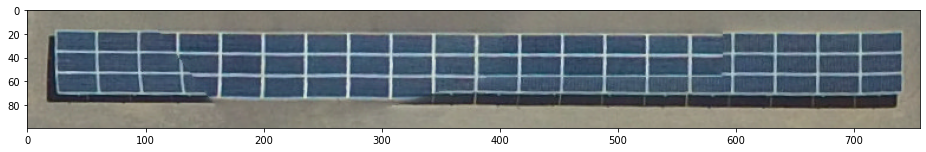

In [14]:
n_string = 60

P_string = L_strings[n_string - 1]['points']
x_min = np.min(P_string[:,0])
x_max = np.max(P_string[:,0])
y_min = np.min(P_string[:,1]) 
y_max = np.max(P_string[:,1])
A = (GR.raster[:3,:,:]).transpose((1, 2, 0))[y_min : y_max, x_min : x_max,:]

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(A)

ax = plt.gca()

for dict_panel in L_strings[n_string - 1]['panels']:
    
    Poly = dict_panel['points'] - (x_min, y_min)
    poly = patches.Polygon(Poly,
                     linewidth=2,
                     edgecolor='red',
                     alpha=0.5,
                     fill = True)
    plt.text(np.mean([x[0]  for x in Poly]), np.mean([y[1]  for y in Poly]) , str(dict_panel['id']),
             bbox=dict(facecolor='red', alpha=0.8), fontsize=6)

    ax.add_patch(poly)


n_panel = 2
name_panel = str(L_strings[n_string - 1]['id']) + '_' + str(L_strings[n_string - 1]['panels'][n_panel-1]['id'])
P = L_strings[n_string - 1]['panels'][n_panel-1]['points']
x_min = np.min(P[:,0])
x_max = np.max(P[:,0])
y_min = np.min(P[:,1]) 
y_max = np.max(P[:,1])
A = (GR.raster[:3,:,:]).transpose((1, 2, 0))[y_min : y_max, x_min : x_max,:]

plt.figure(1)
plt.figure(figsize=(8, 8))
plt.imshow(A)
plt.title(name_panel)


(None,
 4285,
 9031,
 (-69.8876184608113,
  5.284799999996489e-07,
  0.0,
  -18.4429155221439,
  0.0,
  -5.043639999999984e-07),
 <osgeo.osr.SpatialReference; proxy of <Swig Object of type 'OSRSpatialReferenceShadow *' at 0x7f6d2a312ae0> >,
 'Byte')

(-69.8876184608113, 5.284799999996489e-07, 0.0, -18.4429155221439, 0.0, -5.043639999999984e-07)
-69.8870899808113 -18.4434198861439
[3900 2000]
(-69.8873278298117, 5.087700000010391e-07, 0.0, -18.4436753464489, 0.0, -4.855570000001095e-07)


<Figure size 432x288 with 0 Axes>

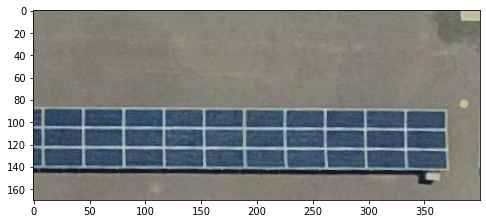

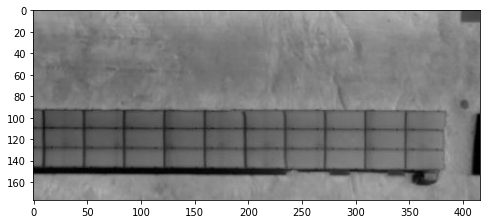

In [75]:
GR = gr.from_file(path_RGB)
geot = GR.geot
print(geot)
pxo_min, pxo_max = 2000,2400
pyo_min, pyo_max = 3900,4070

x_min, y_min = gr.map_pixel_inv(pyo_min, pxo_min,geot[1],geot[-1], geot[0],geot[3])
x_max, y_max = gr.map_pixel_inv(pyo_max, pxo_max,geot[1],geot[-1], geot[0],geot[3])
print(x,y)
print(GR.map_pixel_location(x_min,y_min))
A = (GR.raster[:3,:,:]).transpose((1, 2, 0))[pyo_min : pyo_max, pxo_min : pxo_max,:]

plt.figure(0)
plt.figure(figsize=(8, 8))
plt.imshow(A)

T = gr.from_file(path_T)
geot = T.geot
print(geot)
py_min,px_min = T.map_pixel_location(x_min,y_min)
py_max, px_max = T.map_pixel_location(x_max,y_max)
A = (T.raster[:3,:,:]).transpose((1, 2, 0))[py_min : py_max, px_min : px_max,:]

plt.figure(1)
plt.figure(figsize=(8, 8))
plt.imshow(A)